In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Build LangChain Based LLM Application with RAG and Vector DB (PineCone)

![](https://github.com/simranjeet97/75DayHard_GenAI_LLM_Challenge/blob/main/Day41.png?raw=true)

## Retrieval Augmented Generation (RAG)
It is a pattern that works with pretrained Large Language Models (LLM) and your own data to generate responses.

It combines the powers of pretrained dense retrieval and sequence-to-sequence models. RAG models retrieve documents, pass them to a seq2seq model, then marginalize to generate outputs.

## Create Account on Pinecone and Then get your API Key

In [ ]:
!pip list

In [4]:
PINECONE_API_KEY = 'ca7b56e2-0178-4183-a375-06b9ddc60204'

### Install These Libraries First

In [ ]:
!pip install -qU langchain==0.1.7
!pip install --upgrade langchain-core==0.1.27
!pip install -qU langchain-community==0.0.13
!pip install -qU openai==0.27.7
!pip install -qU tiktoken==0.4.0
!pip install -qU pinecone-client==3.0.0
!pip install -qU pinecone-datasets==0.7.0
!pip install sentence-transformers
!pip install -qU langchain-openai

### Download the Data for the Application

In [ ]:
import pinecone_datasets
dataset = pinecone_datasets.load_dataset('wikipedia-simple-text-embedding-ada-002-100K')

### Pre-Process the Data for Vector DB Storage

Once the data is loaded, you can transform them to suit your application, or to fetch only the relevant parts of the document. Basically, it is about splitting a long document into smaller chunks which can fit your model and give results accurately and clearly.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*K1J78AvIcKglMQh5.png)

In [ ]:
# drop metadata column and renamed blob to metadata
dataset.documents.drop(['metadata'], axis=1, inplace=True)
dataset.documents.rename(columns={'blob': 'metadata'}, inplace=True)


# sample 30k documents
dataset.documents.drop(dataset.documents.index[30_000:], inplace=True)

### Build Pinecone Index 

There is a need of databases so that we can store those embeddings and efficiently search them. Therefore, for storage and searching purpose, we need vector stores. You can retrieve the embedding vectors which will be “most similar”. Basically, it does a vector search for you. There are many vector stores integrated with LangChain, but I have used here “Pinecone” vector store.

In [5]:
from pinecone import Pinecone, PodSpec

pc = Pinecone(api_key=PINECONE_API_KEY)

In [6]:
# Check for and delete index if already exists
index_name = 'langchain-retrieval-augmentation-fast'

In [ ]:
if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)

vectorstore = pc.create_index(
  name=index_name,
  dimension=1536,
  metric="cosine",
  spec=PodSpec(
    environment="gcp-starter"
  )
)

### Insert Data in Pinecone Index
It depends on the length of your dataset, that for how long the above code will run. Mine took 5 minutes and 32 seconds.

In [ ]:
for batch in dataset.iter_documents(batch_size=100):
    index.upsert(batch)

In [ ]:
index = pc.Index(index_name)
index.describe_index_stats()

### Test the Data Fetch and Query from Pinecone using Hugging Face Transformers

In [ ]:
pc.list_indexes()

In [9]:
from transformers import AutoModel, AutoTokenizer
import torch

Embeddings capture the semnatic meaning of the text which allows you to quickly and efficiently find other pieces of text which are similar.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*kZaCc6_CFSd6K2tV.jpg)

### This Embedding function I built for my data as my data has 1536 dimension so I need 1536 dimension of all the queries that I put in my LLM.

In [10]:
def get_concatenated_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # Concatenate embeddings from two layers
    concatenated_embeddings = torch.cat(outputs.hidden_states[-2:], dim=-1)
    
    # Use the mean or another aggregation method based on your requirements
    aggregated_embedding = concatenated_embeddings.sum(dim=1)
    
    return aggregated_embedding.numpy().tolist()[0]

query_text = "FreeBirds Crew"
query_embedding = get_concatenated_embeddings(query_text)
print(len(query_embedding))

1536


### Test Query and Answer
Here I just show you, How you can have your query, build embeddings of it and then insert it into the Vector DB.

In [ ]:
# Index the text embedding in Pinecone
embedding = [{'id': "01", 'values': query_embedding}]
vectorstore.upsert(query_embedding)

In [ ]:
results = vectorstore.query(vector=embedding, top_k=5)
results

In [ ]:
query_text = "What are Power Rangers?"
query_embedding = get_concatenated_embeddings(query_text, tokenizer, model)
len(query_embedding)

In [ ]:
import json
results = vectorstore.query(vector=query_embedding, top_k=1, include_metadata=True)
for result in results["matches"]:
    print(result['score']*100,'%')
    print(result['metadata']['text'])

### Build RAG with Pinecone and LLM

Initialize the vector store
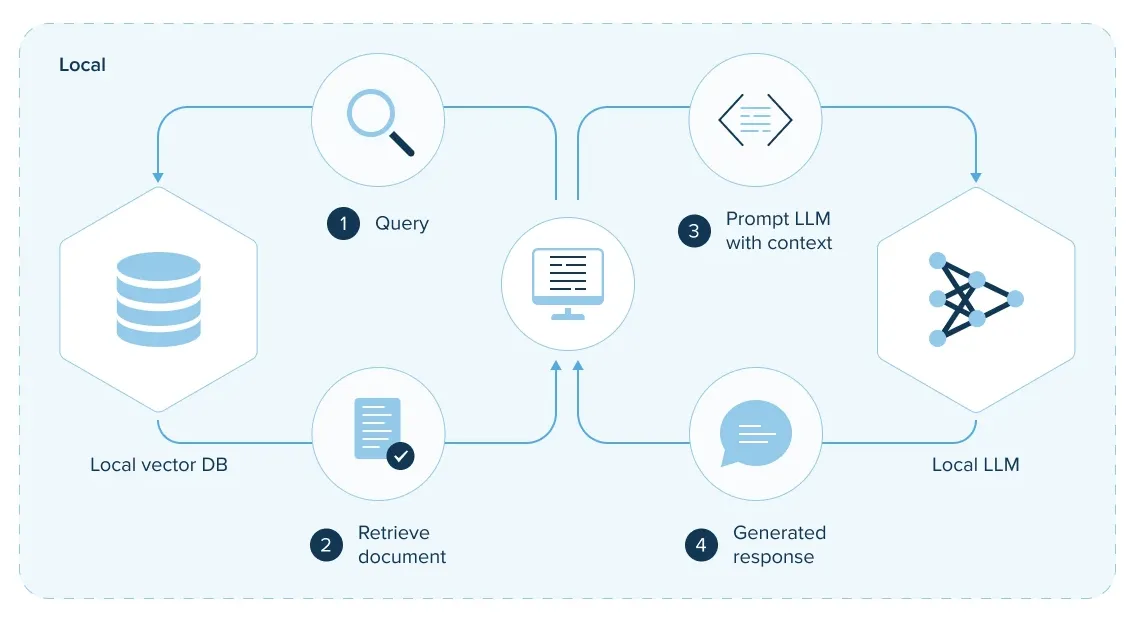

In [11]:
from langchain.vectorstores import Pinecone
vectorstore = Pinecone(index, get_concatenated_embeddings, "text")

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.vectorstores.pinecone.Pinecone` was deprecated in langchain-community 0.0.18 and will be removed in 0.2.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(
/opt/conda/lib/python3.10/site-packages/langchain_community/vectorstores/pinecone.py:68: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


### Query to get Response from LLM and RAG

In [12]:
query = "What is Schizophrenia?"
len(get_concatenated_embeddings(query))

1536

Similarity Search to fine Similar documents in Vector DB

In [13]:
vectorstore.similarity_search(query, k=3)

[Document(page_content='Akron is a large city in the U.S. state of Ohio. It is found near the Ohio & Lake Erie canal. It is home to the U.S. rubber industry, including Goodyear tires.\n\nReferences\n\nOther websites \n\n City of Akron \n Akron Wiki\n\n \nCounty seats in Ohio\n1825 establishments in the United States\n1820s establishments in Ohio', metadata={'chunk': 0.0, 'source': 'https://simple.wikipedia.org/wiki/Akron%2C%20Ohio', 'title': 'Akron, Ohio', 'wiki-id': '17922'}),
 Document(page_content="Google Earth is a virtual globe program that was first called Earth Viewer and was created by Keyhole, Inc.  It maps the surface of the earth by combining pictures taken by satellites and airplanes.  There are also three-dimensional maps where you can look at the area from different angles.  It is quite similar to Google Maps.\n\nGoogle Earth is interactive, and lets the user direct the whole globe, look at satellite imagery with overlays of roads, buildings, geographic features, and more

### Get Response with RAG and LLM + VectorDB (PineCone)

Create a Text2Text Generation pipeline using your pre-trained model and tokenizer and then extend its functionality by creating a LangChain pipeline with additional model-specific arguments.

In [56]:
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=100)
llm = HuggingFacePipeline(pipeline=pipe)
llm

The model 'GPT2LMHeadModel' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].


HuggingFacePipeline(pipeline=<transformers.pipelines.text2text_generation.Text2TextGenerationPipeline object at 0x78f4d04ca920>)

Once the data is in database, the LLM model is prepared, and the pipeline is created, we need to retrieve the data. A retriever **(vectorstore.as_retriever)** is an interface that returns documents from the query.

It is not able to store the documents, only return or retrieves them. Basically, vector stores are the backbone of the retrievers. There are many retriever algorithms in LangChain.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*iCyJRTkc8oI93Bsh.png)

Now, we’re going to use a RetrievalQA chain to find the answer to a question. To do this, we prepared our LLM model with “temperature = 0.7" and “max_length = 512”. You can set your temperature whatever you desire.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*BnhkosPmaEq0xe6E.jpeg)

The RetrievalQA chain, which combines Text2Text-Generation with a retrieval step. To create it, we use a language model and a vector database as a retriever. By default, we put all the data together in a single batch, where the chain type is “stuff” when asking the language model. But if we have a lot of information and it doesn’t all fit at once, we can use methods like MapReduce, Refine, and MapRerank.

In [57]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

In [58]:
response = qa.run(query)

def get_answer(response):
    import re
    question_pattern = re.compile(r"Question: (.+?)\n")
    answer_pattern = re.compile(r"Helpful Answer: (.+?)(?=\n|$)")

    # Find matches
    questions = re.findall(question_pattern, response)
    answers = re.findall(answer_pattern, response)
    
    return [questions, answers]

get_answer(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[['What is Schizophrenia?'],
 ['Schizophrenia is a mental disorder that affects the brain and is characterized by a lack of empathy, impulsivity, and a lack of empathy for others. It is a mental disorder that affects the brain and is characterized by a lack of empathy, impulsivity, and a lack of empathy for others. It is a mental disorder that affects the brain and is characterized by a lack of empathy for others. It is a mental disorder that affects the brain and is characterized by a lack of empathy for others.']]